In [484]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import nltk
from wordcloud import WordCloud
import wordcloud
import utils
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from collections import Counter
from math import pi

In [485]:
# Import data
df_raw=pd.read_csv("/Users/tomcio/Desktop/Project 1/data/philosophy_data.csv")

In [487]:
# Examine data
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB


------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------

Exploratory analysis using .info() pandas function shows that the full dataset has non-null 360808 values in each column, thus confirming that the dataset is complete 

------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------

In [488]:
# Add Sentiment Analysis columns
sia = SentimentIntensityAnalyzer()

# create a new column in the DataFrame to store the sentiment scores
df_raw['sentiment_scores'] = df_raw['sentence_str'].apply(lambda x: sia.polarity_scores(x))

# extract the values from the sentiment_scores dictionary and assign them to new columns
# compound score ranges from -1 (neg) through 0 (neu) to 1 (pos)
df_raw['neg'] = df_raw['sentiment_scores'].apply(lambda x: x['neg'])
df_raw['neu'] = df_raw['sentiment_scores'].apply(lambda x: x['neu'])
df_raw['pos'] = df_raw['sentiment_scores'].apply(lambda x: x['pos'])
df_raw['compound_sent_score'] = df_raw['sentiment_scores'].apply(lambda x: x['compound'])

In [489]:
# Drop columns we are not going to use (all sentiment columns except of compund)
df_raw.drop(columns=['sentence_spacy','corpus_edition_date','sentiment_scores','pos','neg','neu'], inplace=True)

# Rename 'original_publication_date' column to 'year' for operational ease
df_raw.rename(columns = {'original_publication_date':'year'}, inplace = True)
df_raw

,title,author,school,sentence_str,year,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str,compound_sent_score
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...",-350,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea...",-0.2960
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,-350,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...,0.4404
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,-350,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...,-0.3346
3,Plato - Complete Works,Plato,plato,What is this you say?,-350,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?,0.0000
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...",-350,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ...",0.0000
...,...,...,...,...,...,...,...,...,...,...
360803,"Women, Race, And Class",Davis,feminism,But the socialization of housework including m...,1981,142,but the socialization of housework including m...,"['but', 'the', 'socialization', 'of', 'housewo...",but the socialization of housework include me...,0.8462
360804,"Women, Race, And Class",Davis,feminism,The only significant steps toward endingdomest...,1981,117,the only significant steps toward endingdomest...,"['the', 'only', 'significant', 'steps', 'towar...",the only significant step toward endingdomest...,-0.6124
360805,"Women, Race, And Class",Davis,feminism,"Working women, therefore, have a special and v...",1981,90,"working women, therefore, have a special and v...","['working', 'women', 'therefore', 'have', 'spe...","working woman , therefore , have a special an...",0.6808
360806,"Women, Race, And Class",Davis,feminism,"Moreover, under capitalism, campaigns for jobs...",1981,199,"moreover, under capitalism, campaigns for jobs...","['moreover', 'under', 'capitalism', 'campaigns...","moreover , under capitalism , campaign for jo...",0.4939


In [490]:
# Create a dataframe with mean values of sentence length and compound sentiment scores grouped across titles, authors and schools of thought
grouped_df = pd.concat([df_raw.groupby(by=['school','author','title']).mean().round(2), pd.DataFrame(df_raw.groupby(by=['school','author','title'])['title'].count())], axis=1)

# Formatting
grouped_df.rename(columns={'sentence_length': 'mean_sentence_length', 'compound_sent_score': 'mean_compound', 'title': 'freq_of_sentences'}, inplace=True) # rename the mean and freq columns
grouped_df['year'] = grouped_df['year'].apply(lambda x: round(x, -1)) #round the 'year' column entries to the nearest integer
grouped_df['year'] = grouped_df['year'].astype(int) #convert the rounded values in the 'year' column to integers

grouped_df

year  \
school          author          title                                                      
analytic        Kripke          Naming And Necessity                                1970   
                                Philosophical Troubles                              1980   
                Lewis           Lewis - Papers                                      1980   
                Moore           Philosophical Studies                               1910   
                Popper          The Logic Of Scientific Discovery                   1960   
                Quine           Quintessence                                        1950   
                Russell         The Analysis Of Mind                                1920   
                                The Problems Of Philosophy                          1910   
                Wittgenstein    On Certainty                                        1950   
                                Philosophical Investigations                        1950   
                                Tractatus Logico-Philosophicus                      1920   
aristotle       Aristotle       Aristotle - Complete Works                          -320   
capitalism      Keynes          A General Theory Of Employment, Interest, And M...  1940   
                Ricardo         On The Principles Of Political Economy And Taxa...  1820   
                Smith           The Wealth Of Nations                               1780   
communism       Lenin           Essential Works Of Lenin                            1860   
                Marx            Capital                                             1880   
                                The Communist Manifesto                             1850   
continental     Deleuze         Anti-Oedipus                                        1970   
                                Difference And Repetition                           1970   
                Derrida         Writing And Difference                              1970   
                Foucault        History Of Madness                                  1960   
                                The Birth Of The Clinic                             1960   
                                The Order Of Things                                 1970   
empiricism      Berkeley        A Treatise Concerning The Principles Of Human K...  1710   
                                Three Dialogues                                     1710   
                Hume            A Treatise Of Human Nature                          1740   
                                Dialogues Concerning Natural Religion               1780   
                Locke           Essay Concerning Human Understanding                1690   
                                Second Treatise On Government                       1690   
feminism        Beauvoir        The Second Sex                                      1950   
                Davis           Women, Race, And Class                              1980   
                Wollstonecraft  Vindication Of The Rights Of Woman                  1790   
german_idealism Fichte          The System Of Ethics                                1800   
                Hegel           Elements Of The Philosophy Of Right                 1820   
                                Science Of Logic                                    1820   
                                The Phenomenology Of Spirit                         1810   
                Kant            Critique Of Judgement                               1790   
                                Critique Of Practical Reason                        1790   
                                Critique Of Pure Reason                             1780   
nietzsche       Nietzsche       Beyond Good And Evil                                1890   
                                Ecce Homo                                           1890   
                                The 

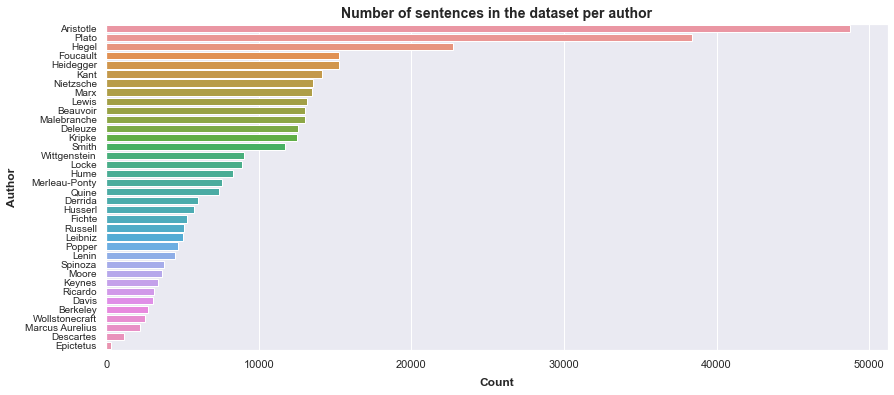

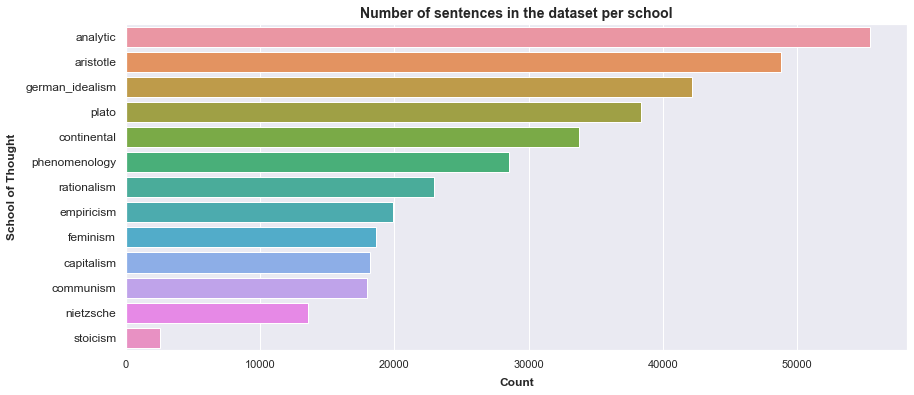

In [491]:
# create the first figure and subplot
fig1, ax1 = plt.subplots(1, 1)

# set the size and background color of the figure
fig1.set_size_inches(14, 6)
fig1.set_facecolor('white')

# create the first bar plot
sns.countplot(y='author', data=df_raw, order = df_raw['author'].value_counts().index, ax=ax1)
ax1.grid(True, axis='x')
ax1.set_yticklabels(ax1.get_yticklabels(), size = 10)
ax1.set_title('Number of sentences in the dataset per author', fontsize=14, fontweight='bold')
ax1.set_ylabel('Author', fontsize=12, labelpad=8, fontweight='bold')
ax1.set_xlabel('Count', fontsize=12, labelpad=8, fontweight='bold')

plt.show()

# create the second figure and subplot
fig2, ax2 = plt.subplots(1, 1)

# set the size and background color of the figure
fig2.set_size_inches(14, 6)
fig2.set_facecolor('white')

# create the second bar plot
sns.countplot(y='school', data=df_raw, order = df_raw['school'].value_counts().index, ax=ax2)
ax2.set_yticklabels(ax2.get_yticklabels(), size = 12)
ax2.set_title('Number of sentences in the dataset per school', fontsize=14, fontweight='bold')
ax2.set_ylabel('School of Thought', fontsize=12, labelpad=8, fontweight='bold')
ax2.set_xlabel('Count', fontsize=12, labelpad=8, fontweight='bold')

plt.show()

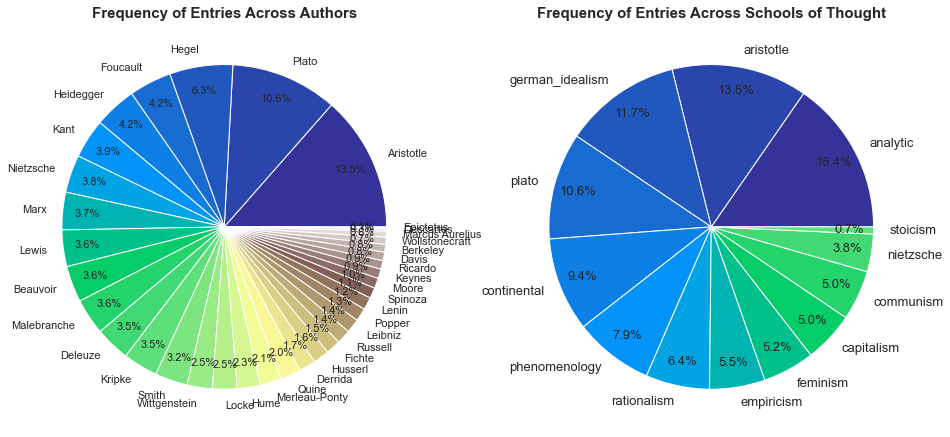

In [492]:
# count the number of entries for each author
author_counts = df_raw['author'].value_counts()
school_counts = df_raw['school'].value_counts()

# extract the labels (author names) and values (counts) from the Series
labels_author = author_counts.index
values_author = author_counts.values
labels_school = school_counts.index
values_school = school_counts.values

# create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set the size and background color of the subplots
fig.set_size_inches(16, 10)
fig.set_facecolor('white')

# define the labels variable
labels = ['Label {}'.format(i) for i in range(len(values_author))]

# create a rainbow gradient colormap
colormap = cm.terrain(np.linspace(0, 1, len(labels)))

# create the first pie chart with the percentage labels closer to the edge
ax1.pie(values_author, labels=labels_author, autopct='%1.1f%%', pctdistance=0.85, colors=colormap, textprops={'fontsize': 11})
ax1.set_title('Frequency of Entries Across Authors', fontsize=15, fontweight='bold')


# create the second pie chart with the percentage labels closer to the edge
ax2.pie(values_school, labels=labels_school, autopct='%1.1f%%', pctdistance=0.85, colors=colormap, textprops={'fontsize': 13})
ax2.set_title('Frequency of Entries Across Schools of Thought', fontsize=15, fontweight='bold')


plt.show()

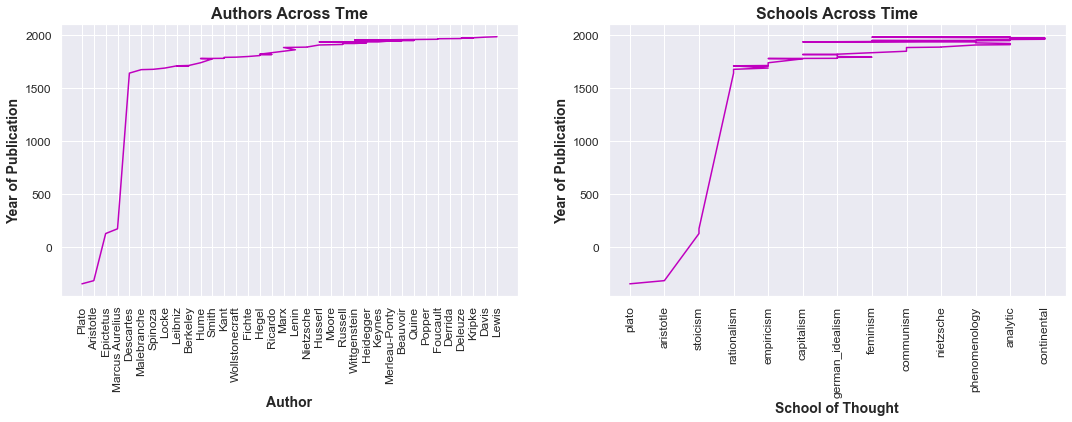

In [493]:
# Line plot representing the distribution of philosophers across time
time_dat_raw = df_raw[['author', 'year']].sort_values(by=['year'], ascending=True)

# Create a figure with size (16, 10) inches
fig = plt.figure(figsize=(18, 5))

# Create a subplot with 1 row and 2 columns, and set the current subplot to be the first subplot
plt.subplot(1, 2, 1)

# Plot the first line plot
plt.plot(time_dat_raw['author'], time_dat_raw['year'], color='#bf00bf')
plt.xticks(rotation=90)
plt.tick_params(labelsize=12)  # Decrease the font size of the tick labels
plt.xlabel('Author', fontsize=14, fontweight='bold')
plt.ylabel('Year of Publication', fontsize=14, fontweight='bold')
plt.title("Authors Across Tme", fontsize=16, fontweight='bold')

# Set the current subplot to be the second subplot
plt.subplot(1, 2, 2)

# Line plot representing the distribution of philosophers across time
time_dat_raw = df_raw[['school', 'year']].sort_values(by=['year'], ascending=True)

# Plot the second line plot
plt.plot(time_dat_raw['school'], time_dat_raw['year'], color='#bf00bf')
plt.xticks(rotation=90)
plt.tick_params(labelsize=12)  # Decrease the font size of the tick labels
plt.xlabel('School of Thought', fontsize=14, fontweight='bold')
plt.ylabel('Year of Publication', fontsize=14, fontweight='bold')
plt.title("Schools Across Time", fontsize=16, fontweight='bold')

# Show the plots
plt.show()

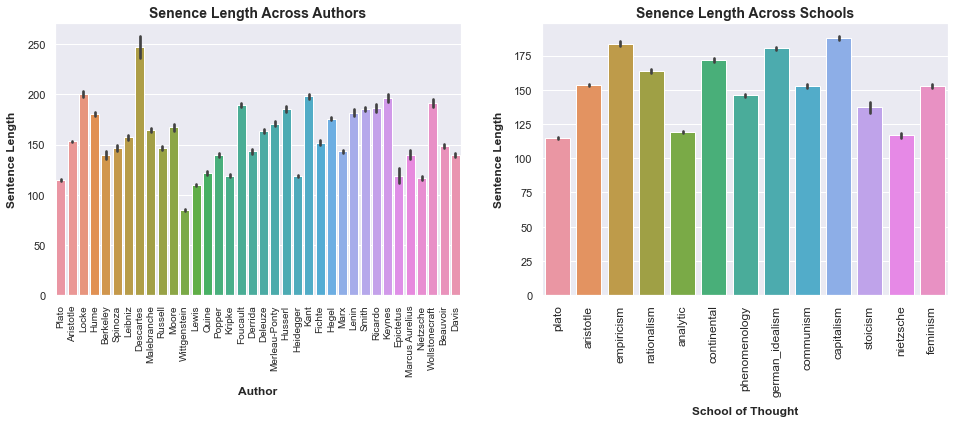

In [494]:
# create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set the size and background color of the subplots
fig.set_size_inches(16, 5)
fig.set_facecolor('white')

# create the first bar plot
sns.barplot(x='author', y='sentence_length', data=df_raw, ax=ax1)
ax1.grid(True, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, size = 10)
ax1.set_ylabel("Sentence Length", fontsize=12, labelpad=10, fontweight='bold')
ax1.set_xlabel('Author', fontsize=12, labelpad=10, fontweight='bold')
ax1.set_title("Senence Length Across Authors", fontsize=14, fontweight='bold')



# create the second bar plot
sns.barplot(x='school', y='sentence_length', data=df_raw, ax=ax2)
ax2.grid(True, axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, size = 12)
ax2.set_ylabel('Sentence Length', fontsize=12, labelpad=10, fontweight='bold')
ax2.set_xlabel('School of Thought', fontsize=12, labelpad=10, fontweight='bold')
ax2.set_title("Senence Length Across Schools", fontsize=14, fontweight='bold')


plt.show()



Text(0, 0.5, 'Compound Sentiment Value')

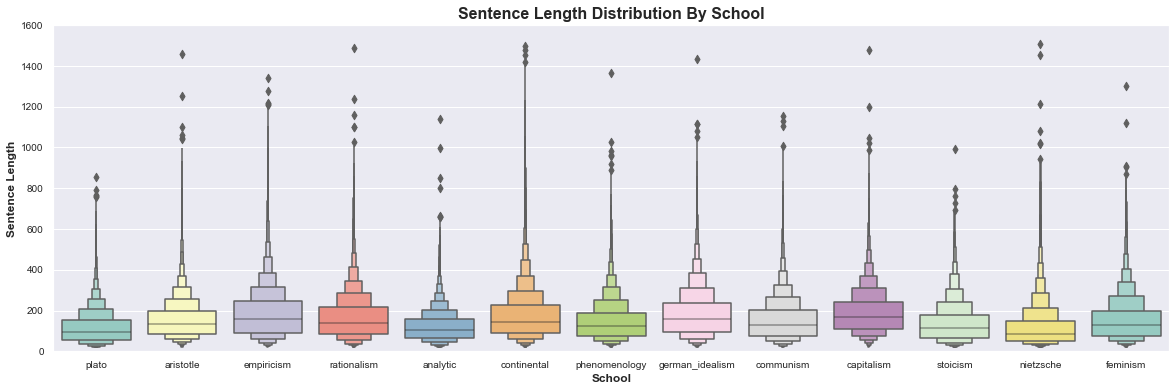

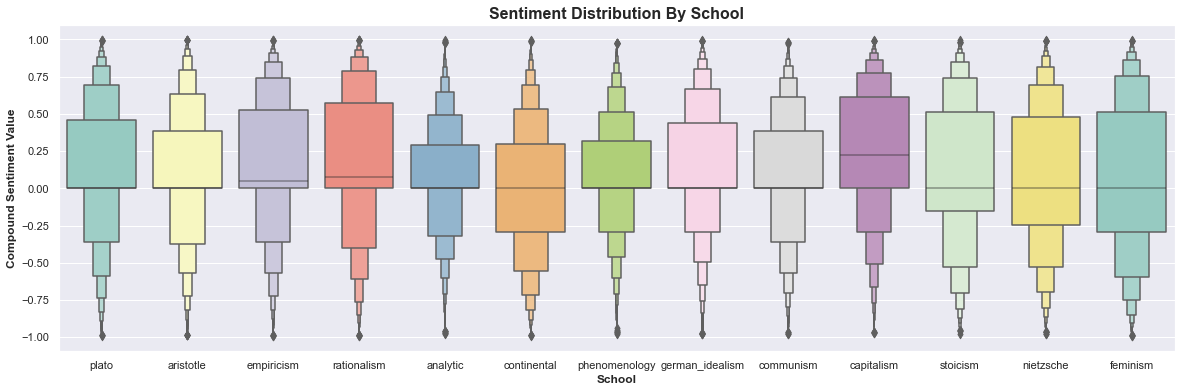

In [495]:

# plot sentence length split by school
plt.figure(figsize=(20,6))
sns.set(font_scale=1.5)
sns.boxenplot(x='school', y='sentence_length', data=df_raw, palette="Set3")
plt.title('Sentence Length Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Sentence Length', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10) # Decrease tick size
plt.ylim(0,1600) # Limit y-axis range

# plot compound sentiment split by school
plt.figure(figsize=(20,6))
sns.set(font_scale=1)
sns.boxenplot(x='school', y='compound_sent_score', data=df_raw, palette="Set3")
plt.title('Sentiment Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Compound Sentiment Value', fontsize=12, fontweight='bold')



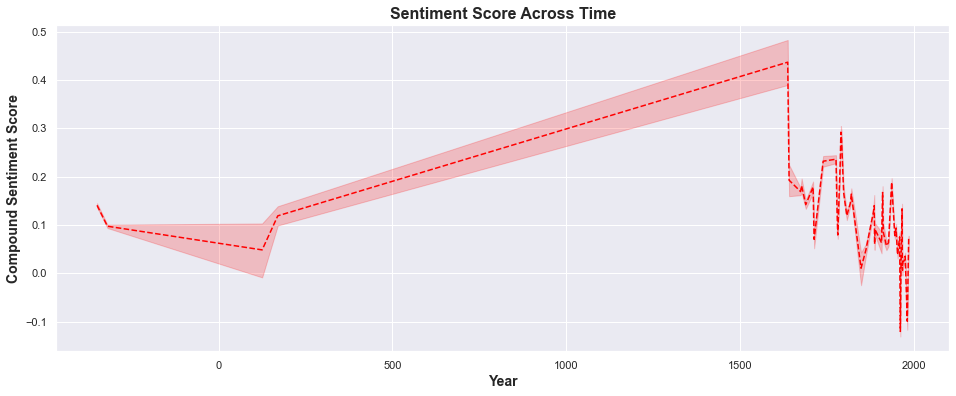

In [496]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df_raw, x='year', y='compound_sent_score', linestyle='--', color='red')
plt.grid(True)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, fontweight='bold')
plt.title("Sentiment Score Across Time", fontsize=16, fontweight='bold')
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------

Analysing Analytic vs Continental

------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------

In [497]:
# Isolate solely the rows for which school is equal to either 'analytic' or 'continental'
df = df_raw.loc[df_raw['school'].isin(['analytic', 'continental'])]
df = df.reset_index(drop=True)

# Create a dataframe with mean values of sentence length and compound sentiment scores grouped across titles, authors and schools of thought
grouped_df_2 = pd.concat([df.groupby(by=['school','author','title']).mean().round(2), pd.DataFrame(df.groupby(by=['school','author','title'])['title'].count())], axis=1)

# Formatting
grouped_df_2.rename(columns={'sentence_length': 'mean_sentence_length', 'compound_sent_score': 'mean_compound', 'title': 'freq_of_sentences'}, inplace=True) # rename the mean and freq columns
grouped_df_2['year'] = grouped_df['year'].apply(lambda x: round(x, -1)) #round the 'year' column entries to the nearest integer
grouped_df_2['year'] = grouped_df['year'].astype(int) #convert the rounded values in the 'year' column to integers

grouped_df_2


year  \
school      author       title                                     
analytic    Kripke       Naming And Necessity               1970   
                         Philosophical Troubles             1980   
            Lewis        Lewis - Papers                     1980   
            Moore        Philosophical Studies              1910   
            Popper       The Logic Of Scientific Discovery  1960   
            Quine        Quintessence                       1950   
            Russell      The Analysis Of Mind               1920   
                         The Problems Of Philosophy         1910   
            Wittgenstein On Certainty                       1950   
                         Philosophical Investigations       1950   
                         Tractatus Logico-Philosophicus     1920   
continental Deleuze      Anti-Oedipus                       1970   
                         Difference And Repetition          1970   
            Derrida      Writing And Difference             1970   
            Foucault     History Of Madness                 1960   
                         The Birth Of The Clinic            1960   
                         The Order Of Things                1970   

                                                            mean_sentence_length  \
school      author       title                                                     
analytic    Kripke       Naming And Necessity                             120.57   
                         Philosophical Troubles                           118.60   
            Lewis        Lewis - Papers                                   109.72   
            Moore        Philosophical Studies                            167.25   
            Popper       The Logic Of Scientific Discovery                139.55   
            Quine        Quintessence                                     121.64   
            Russell      The Analysis Of Mind                             142.64   
                         The Problems Of Philosophy                       154.54   
            Wittgenstein On Certainty                                      79.38   
                         Philosophical Investigations                      83.58   
                         Tractatus Logico-Philosophicus                   100.19   
continental Deleuze      Anti-Oedipus                                     165.51   
                         Difference And Repetition                        161.58   
            Derrida      Writing And Difference                           143.43   
            Foucault     History Of Madness                               174.42   
                         The Birth Of The Clinic                          184.99   
                         The Order Of Things                              218.20   

                                                            mean_compound  \
school      author       title                                              
analytic    Kripke       Naming And Necessity                        0.06   
                         Philosophical Troubles                      0.04   
            Lewis        Lewis - Papers                              0.07   
            Moore        Philosophical Studies                       0.17   
            Popper       The Logic Of Scientific Discovery           0.08   
            Quine        Quintessence                                0.10   
            Russell      The Analysis Of Mind                        0.06   
                         The Problems Of Philosophy                  0.09   
            Wittgenstein On Certainty                                0.03   
                         Philosophical Investigations                0.04   
                         Tractatus Logico-Philosophicus              0.05   
continental Deleuze      Anti-Oedipus                                0.01   
                         Difference And Repetition                   0.02   
            Der

In [498]:
# Isolate two dataframes: one for analytic entries and one for continental entries
df_analytic = df.loc[df['school'].isin(['analytic'])]
df_continental = df.loc[df['school'].isin(['continental'])]


Text(0, 0.5, 'Compound Sentiment Value')

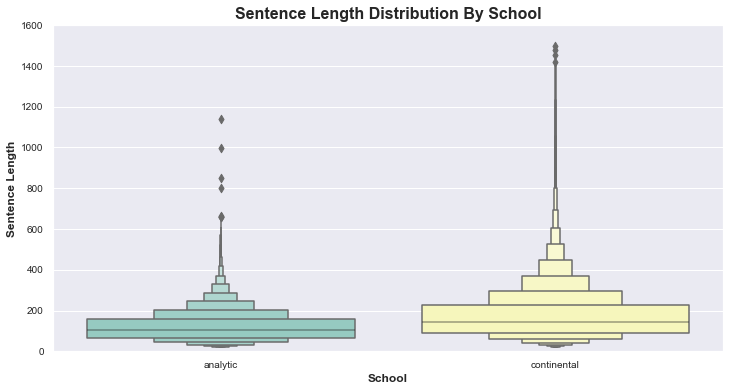

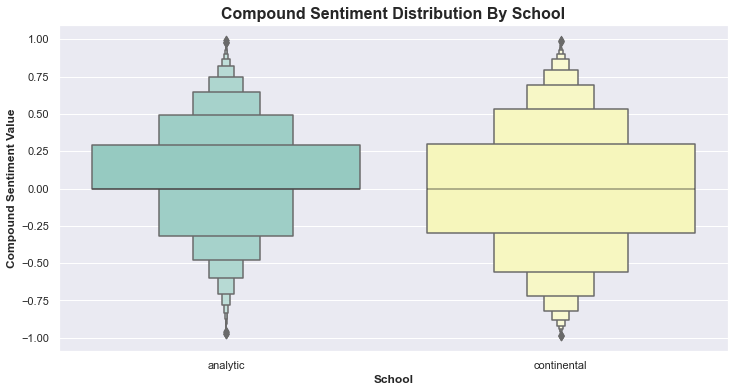

In [499]:
# plot sentence length split by school
plt.figure(figsize=(12,6))
sns.set(font_scale=1.5)
sns.boxenplot(x='school', y='sentence_length', data=df, palette="Set3")
plt.title('Sentence Length Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Sentence Length', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10) # Decrease tick size
plt.ylim(0,1600) # Limit y-axis range

# plot compound sentiment split by school
plt.figure(figsize=(12,6))
sns.set(font_scale=1)
sns.boxenplot(x='school', y='compound_sent_score', data=df, palette="Set3")
plt.title('Compound Sentiment Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Compound Sentiment Value', fontsize=12, fontweight='bold')

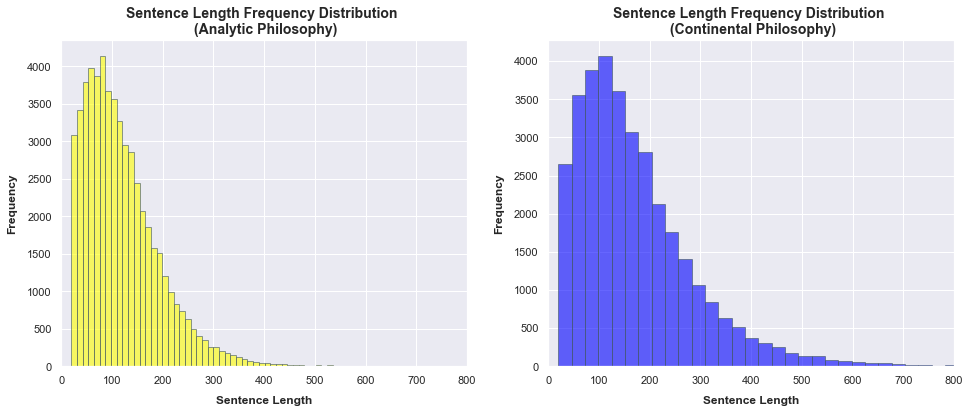

In [500]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Extract the sentence lengths from the data
sentence_lengths_analytic = df_analytic['sentence_length']

# Plot the first histogram in the first subplot
ax[0].hist(sentence_lengths_analytic, 100, color='#FFFF00', alpha=0.6, edgecolor='#455A64')

# Add a title and axis labels to the first subplot
ax[0].set_title('Sentence Length Frequency Distribution \n (Analytic Philosophy)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Sentence Length', fontsize=12, labelpad=10, fontweight='bold')
ax[0].set_ylabel('Frequency', fontsize=12, labelpad=10, fontweight='bold')
ax[0].set_xlim(0, 800)


# Extract the sentence lengths from the data
sentence_lengths_continental = df_continental['sentence_length']

# Plot the second histogram in the second subplot
ax[1].hist(sentence_lengths_continental, 100, color='#0000FF', alpha=0.6, edgecolor='#455A64')

# Add a title and axis labels to the second subplot
ax[1].set_title('Sentence Length Frequency Distribution \n (Continental Philosophy)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Sentence Length', fontsize=12, labelpad=10, fontweight='bold')
ax[1].set_ylabel('Frequency', fontsize=12, labelpad=10, fontweight='bold')
ax[1].set_xlim(0, 800)

# Show the plot
plt.show()

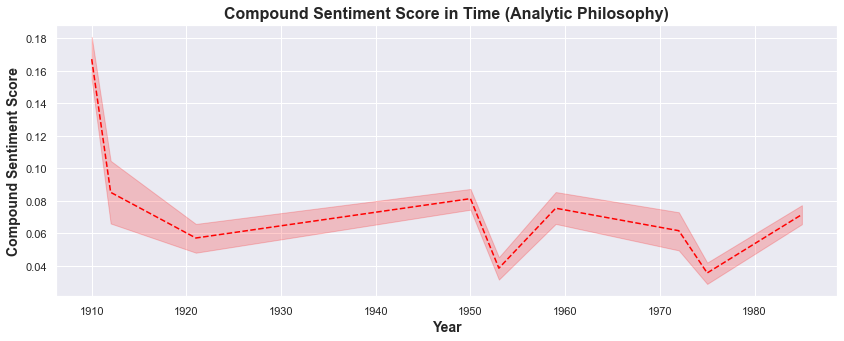

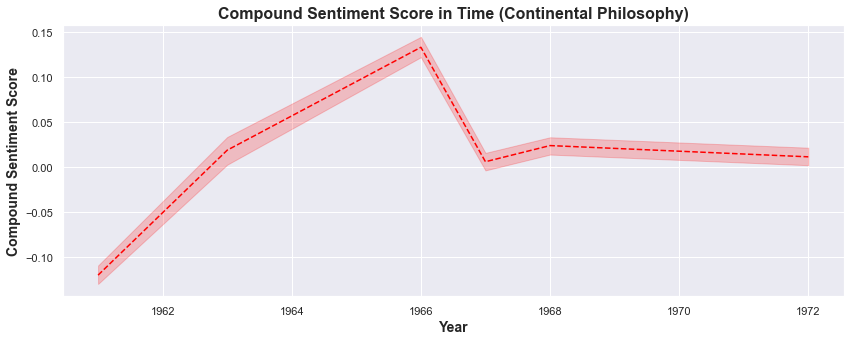

In [501]:
plt.figure(figsize=(14,5))
sns.lineplot(data=df_analytic, x='year', y='compound_sent_score', linestyle='--', color='red')
plt.grid(True)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, fontweight='bold')
plt.title("Compound Sentiment Score in Time (Analytic Philosophy)", fontsize=16, fontweight='bold')
plt.show()

plt.figure(figsize=(14,5))
sns.lineplot(data=df_continental, x='year', y='compound_sent_score', linestyle='--', color='red')
plt.grid(True)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, fontweight='bold')
plt.title("Compound Sentiment Score in Time (Continental Philosophy)", fontsize=16, fontweight='bold')
plt.show()

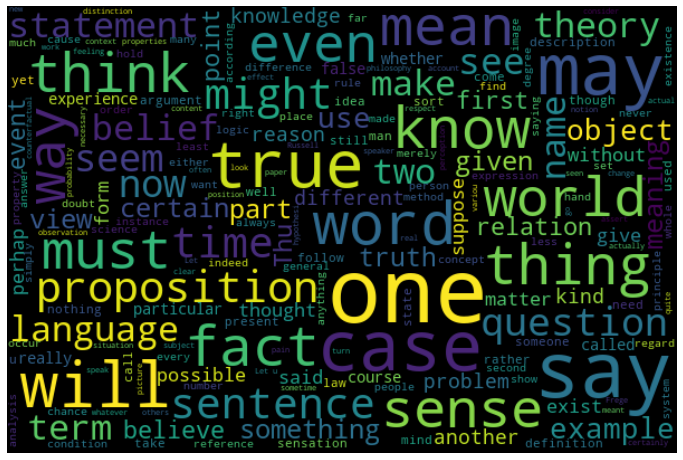

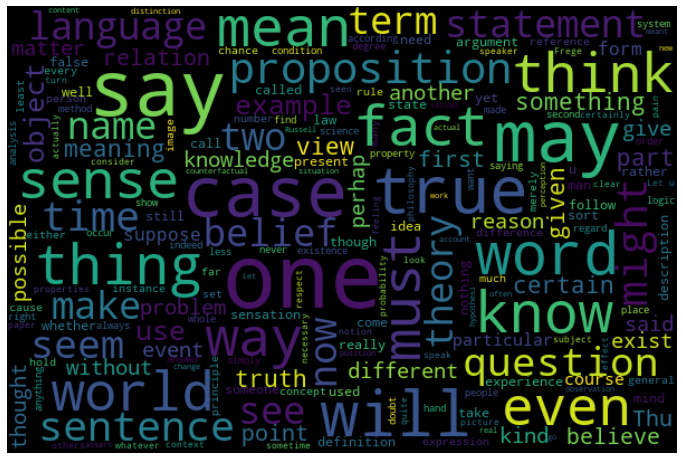

In [502]:
# Wordcloud for Analytical
# create an empty string to store all the sentences
all_sentences = ' '.join(df_analytic['sentence_str'])

# create a wordcloud object
wordcloud = WordCloud(max_font_size=80, width=600, height=400).generate(all_sentences)

# plot the wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Wordcloud for Continental
# create an empty string to store all the sentences
all_sentences = ' '.join(df_analytic['sentence_str'])

# create a wordcloud object
wordcloud = WordCloud(max_font_size=80, width=600, height=400).generate(all_sentences)

# plot the wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------

Emotion classification

------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------

In [503]:
# Using NRCLex to get main emotions of each sentence in the df
# Create an empty list to store the emotion labels
emotion_labels = []

# Iterate through the rows of the dataframe
for i, row in df.iterrows():
  # Get the lemmatized text
  lemmatized_text = row['lemmatized_str']

  # Create an NRCLex object for the text
  emotion = NRCLex(lemmatized_text)

  # Get the top emotion for the text
  top_emotion = emotion.top_emotions

  # Append the top emotion label to the list
  emotion_labels.append(top_emotion)

# Create an empty list to store the main emotions
primary_emotions = []
secondary_emotions = []


# Iterate through the emotion labels
for emotion in emotion_labels:
  # Extract the primary emotion from the emotion tuple
  main_emotion = emotion[0][0]

  # Append the secondary and primary emotion to the list
  primary_emotions.append(main_emotion)
  if len(emotion) > 1:
      secondary_emotion = emotion[1][0]
  else:
      secondary_emotion = main_emotion
  secondary_emotions.append(secondary_emotion)


df['primary_emotion'] = primary_emotions
df['secondary_emotion'] = secondary_emotions



In [504]:
df

,title,author,school,sentence_str,year,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str,compound_sent_score,primary_emotion,secondary_emotion
0,The Analysis Of Mind,Russell,analytic,This book has grown out of an attempt to harmo...,1921,217,this book has grown out of an attempt to harmo...,"['this', 'book', 'has', 'grown', 'out', 'of', ...",this book have grow out of an attempt to harm...,0.6369,positive,positive
1,The Analysis Of Mind,Russell,analytic,"On the one hand, many psychologists, especiall...",1921,186,"on the one hand, many psychologists, especiall...","['on', 'the', 'one', 'hand', 'many', 'psycholo...","on the one hand , many psychologist , especia...",0.6124,trust,trust
2,The Analysis Of Mind,Russell,analytic,They make psychology increasingly dependent on...,1921,167,they make psychology increasingly dependent on...,"['they', 'make', 'psychology', 'increasingly',...",-PRON- make psychology increasingly dependent...,0.2484,positive,positive
3,The Analysis Of Mind,Russell,analytic,"Meanwhile the physicists, especially Einstein ...",1921,142,"meanwhile the physicists, especially einstein ...","['meanwhile', 'the', 'physicists', 'especially...","meanwhile the physicist , especially Einstein...",0.0258,trust,trust
4,The Analysis Of Mind,Russell,analytic,"Their world consists of events, from which mat...",1921,87,"their world consists of events, from which mat...","['their', 'world', 'consists', 'of', 'events',...","-PRON- world consist of event , from which ma...",0.0258,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
89199,Anti-Oedipus,Deleuze,continental,We'll never go too far with the deterritoriali...,1972,76,we'll never go too far with the deterritoriali...,"['we', 'll', 'never', 'go', 'too', 'far', 'wit...",-PRON- will never go too far with the deterri...,0.0000,positive,positive
89200,Anti-Oedipus,Deleuze,continental,"In truth, the earth will one day become a plac...",1972,58,"in truth, the earth will one day become a plac...","['in', 'truth', 'the', 'earth', 'will', 'one',...","in truth , the earth will one day become a pl...",0.3182,trust,positive
89201,Anti-Oedipus,Deleuze,continental,is not to be found in the neurotic or perverse...,1972,111,is not to be found in the neurotic or perverse...,"['is', 'not', 'to', 'be', 'found', 'in', 'the'...",be not to be find in the neurotic or perverse...,-0.7650,negative,negative
89202,Anti-Oedipus,Deleuze,continental,"; it is no more behind than ahead, it coincide...",1972,199,"; it is no more behind than ahead, it coincide...","['it', 'is', 'no', 'more', 'behind', 'than', '...","; -PRON- be no more behind than ahead , -PRON...",-0.2960,positive,anticipation


In [505]:
df_analytic = df.loc[df['school'].isin(['analytic'])]
df_continental = df.loc[df['school'].isin(['continental'])]

In [506]:

emot_freq_analytical = dict(Counter(df_analytic["primary_emotion"]))
emot_freq_continental = dict(Counter(df_continental["primary_emotion"]))

emot_freq_df = pd.DataFrame([emot_freq_analytical, emot_freq_continental])
selected_schools = ['analytic','continental']
emot_freq_df.insert(0, 'school', selected_schools)
emot_freq_df.insert(6, 'trust', emot_freq_df.pop('trust'))
emot_freq_df.insert(9, 'fear', emot_freq_df.pop('fear'))



sec_emot_freq_analytical = dict(Counter(df_analytic["secondary_emotion"]))
sec_emot_freq_continental = dict(Counter(df_continental["secondary_emotion"]))

sec_emot_freq_df = pd.DataFrame([sec_emot_freq_analytical, sec_emot_freq_continental])
sec_emot_freq_df.insert(0, 'school', selected_schools)
sec_emot_freq_df.insert(6, 'trust', sec_emot_freq_df.pop('trust'))
sec_emot_freq_df.insert(9, 'fear', sec_emot_freq_df.pop('fear'))



In [507]:
emot_freq_df

,school,positive,negative,anticipation,anger,trust,surprise,disgust,sadness,fear,joy
0,analytic,15084,3882,2286,1688,14139,1145,40,187,16960,14
1,continental,11009,4635,980,959,7090,457,31,139,8426,53


In [508]:
sec_emot_freq_df

,school,positive,negative,anticipation,anger,surprise,trust,sadness,joy,fear,disgust
0,analytic,21699,7239,4044,12639,1467,6478,951,316,419,173
1,continental,13557,6972,2060,5528,626,3525,731,200,460,120


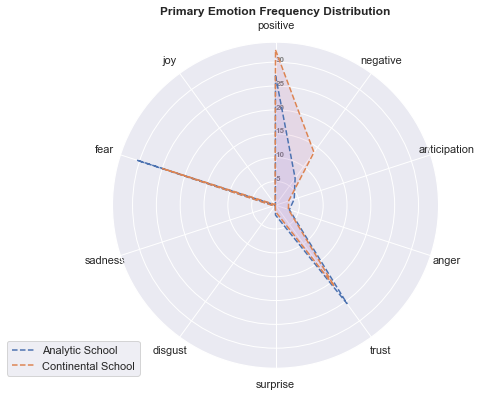

In [509]:
# Set figure size
plt.figure(figsize=(26, 6))

# number of variable
categories=list(emot_freq_df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Add title
plt.title('Primary Emotion Frequency Distribution', fontsize=12, fontweight='bold')


# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(color="grey", size=8, fontweight='bold')


# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values = emot_freq_df.loc[0].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Analytic School")

polys = ax.fill(angles, values, alpha=0.1)

# Set color for fill between lines and axes for group A
polys[0].set_facecolor(cm.cool(0.5))  # use 0.5 as the color value for the cool colormap
 
# Ind2
values = emot_freq_df.loc[1].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Continental School")
polys = ax.fill(angles, values, alpha=0.1)

# Set color for fill between lines and axes for group B
polys[0].set_facecolor(cm.magma(0.5))  # use 0.5 as the color value for the cool colormap
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

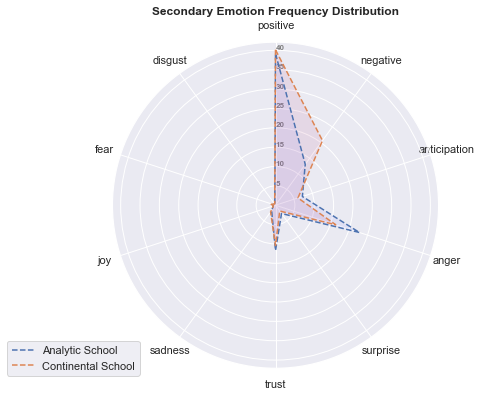

In [510]:
# Set figure size
plt.figure(figsize=(26, 6))

# number of variable
categories=list(sec_emot_freq_df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Add title
plt.title('Secondary Emotion Frequency Distribution', fontsize=12, fontweight='bold')


# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(color="grey", size=8, fontweight='bold')


# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values = sec_emot_freq_df.loc[0].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Analytic School")

polys = ax.fill(angles, values, alpha=0.1)

# Set color for fill between lines and axes for group A
polys[0].set_facecolor(cm.cool(0.5))  # use 0.5 as the color value for the cool colormap
 
# Ind2
values = sec_emot_freq_df.loc[1].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Continental School")
polys = ax.fill(angles, values, alpha=0.1)

# Set color for fill between lines and axes for group B
polys[0].set_facecolor(cm.magma(0.5))  # use 0.5 as the color value for the cool colormap
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()